# FAST-UAV - Design of Experiments 

*Author: Félix Pollet - 2023* <br>

The `doe_fast` module offers the capability of running design of experiments on a FAST-UAV problem.

Various generators are available:
* The `List` generator reads cases from a user-defined array of DoE cases
* The `Uniform` generator creates random samples drawn from a uniform distribution
* The `Latin Hypercube` generator instanciates a [latin hypercube sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling)
* The `Sobol` generator instanciates the [Sobol-Saltelli 2002 method provided by SALib](https://salib.readthedocs.io/en/latest/api.html#sobol-sensitivity-analysis). It is useful for performing a Sobol analysis, which is a form of [variance-based sensitivity analysis](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis).
* The `Morris` generator instanciates the [method of Morris provided by SALib](https://salib.readthedocs.io/en/latest/api.html#method-of-morris). The [method of Morris](https://en.wikipedia.org/wiki/Morris_method) is a one-step-at-a-time method (OAT) for sensitivity analysis.

The examples below show some applications of the module.

In [12]:
# Import required librairies
import os.path as pth
import fastoad.api as oad
from fastuav.utils.postprocessing.sensitivity_analysis.sensitivity_analysis import doe_fast
import numpy as np
import plotly.graph_objects as go
import plotly

DATA_FOLDER_PATH = "../data/doe"
WORK_FOLDER_PATH = "./workdir"

CONFIGURATION_FILE = pth.join(WORK_FOLDER_PATH, "conf_file_doe.yaml")

## Example 1: running a model for many different input values

In [13]:
# Generate the configuration file for the problem to be evaluated
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="doe_simple_model.yaml"
)

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\conf_file_doe.yaml'

In [14]:
# Generate the inputs file and display data
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_inputs_doe.xml")
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

In [15]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

In [16]:
# Definition of the DoE

# Inputs to be varied
x_dict = {
    "mission:operational:main_route:payload:mass": [0.5, 4.0],  # range of variation
    "mission:operational:main_route:cruise:speed": [10.0, 20.0]
         }

# Output(s) to observe
y_list = [
    "mission:operational:main_route:energy",
]

In [17]:
# Run DoE
method = "fullfactorial"  # full factorial sampling
n_samples = 10  # Number of samples
df = doe_fast(method, x_dict, y_list, CONFIGURATION_FILE, n_samples)

C:\Users\f.pollet.ISAE-SUPAERO\AppData\Roaming\Python\Python38\site-packages\openmdao\visualization\n2_viewer\n2_viewer.py:168: OpenMDAOWarning:All-NaN slice encountered
C:\Users\f.pollet.ISAE-SUPAERO\AppData\Roaming\Python\Python38\site-packages\openmdao\visualization\n2_viewer\n2_viewer.py:168: OpenMDAOWarning:All-NaN slice encountered


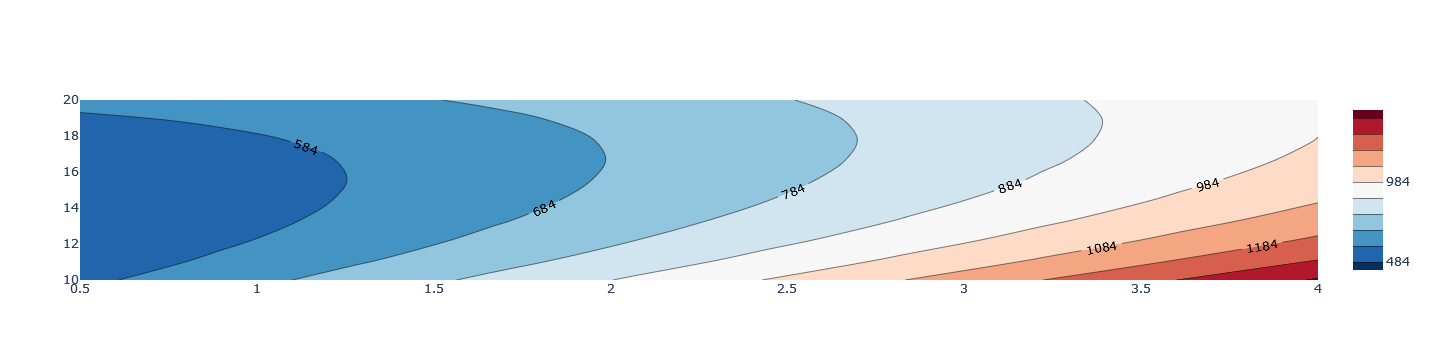

In [28]:
# Plot DoE with Plotly

# Set variables to plot
x_name = list(x_dict.keys())[0]
y_name = list(x_dict.keys())[1]
z_name = y_list[0]

# Reshape data into a grid
x_vals = sorted(df[x_name].unique())
y_vals = sorted(df[y_name].unique())
#y_vals = [val / 1000 for val in y_vals]
z_grid = df.pivot(index=y_name, columns=x_name, values=z_name).values

# Create the contour plot    
fig = go.Figure()
fig.add_trace(go.Contour(
    x=x_vals, y=y_vals, z=z_grid, 
    connectgaps=True,
    contours=dict(start=df[z_name].min(), end=df[z_name].max(), showlabels=True),
    colorscale='RdBu_r' # Blackbody,Bluered,Blues,Cividis,Earth,Electric,Greens,Greys,Hot,Jet,Picnic,Portland,Rainbow,RdBu,Reds,Viridis,YlGnBu,YlOrRd. (add '_r' for reversed)
))

# Display the plot
fig.show()

## Example 2: DoE on the optimization problem

Sometimes you may want to run a DoE on an optimization problem rather than a model. The `doe_fast` module automatically detects if an optimization problem is defined in the configuration file, and each point of the DoE will run an optimization.

In [29]:
# Configuration file with an optimization problem
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="doe_optimization_problem.yaml"
)

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\conf_file_doe.yaml'

In [31]:
# Generate the inputs file and display data
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_inputs_doe_2.xml")
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

In [52]:
# Definition of the DoE

# Inputs to be varied
x_dict = {
    "data:weight:propulsion:multirotor:battery:mass:reference": [0.5, 1.0],  # range of variation
    "mission:sizing:main_route:hover:duration": [10, 40]
         }

# Outputs to observe
#y_list = ["data:weight:mtow", "mission:operational:energy"]
y_list = ["data:weight:mtow", "data:weight:propulsion:multirotor:battery:mass", "data:propulsion:multirotor:battery:energy","data:performance:range:cruise", "data:performance:endurance:hover"]

# Run DoE
#method = "lhs"  # LHS sampling
method = "fullfactorial"  # full factorial sampling
n_samples = 10  # Number of samples
df = doe_fast(method, x_dict, y_list, CONFIGURATION_FILE, n_samples)

C:\Users\f.pollet.ISAE-SUPAERO\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



19 out of 100 optimizations failed.


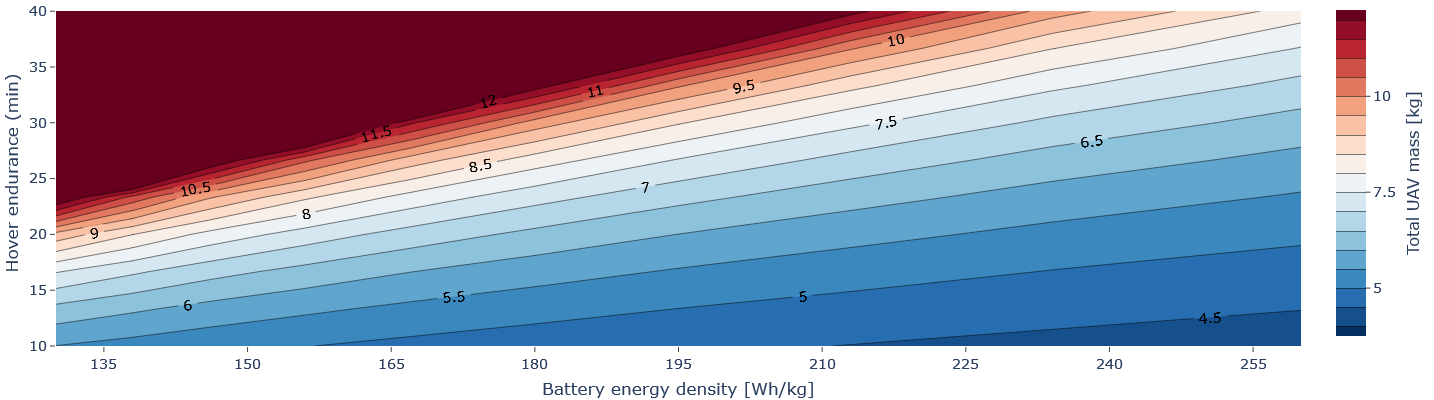

In [154]:
# Plot DoE with Plotly

# Minor calculations on the dataframe for better plotting
df = df.drop(df[df.optim_failed == 1.0].index)
df["data:propulsion:multirotor:battery:energy:density"] = df["data:propulsion:multirotor:battery:energy"] / 3.6 / df["data:weight:propulsion:multirotor:battery:mass"]
df["data:propulsion:multirotor:battery:energy:density"] = df["data:propulsion:multirotor:battery:energy:density"].astype(int)

# Set variables to plot
x_name = "data:propulsion:multirotor:battery:energy:density"
y_name = "mission:sizing:main_route:hover:duration"
z_name = "data:weight:mtow"

# Reshape data into a grid
x_vals = sorted(df[x_name].unique())
y_vals = sorted(df[y_name].unique())
z_grid = df.pivot(index=y_name, columns=x_name, values=z_name).values

# Create the contour plot    
fig = go.Figure()
fig.add_trace(go.Contour(
    x=x_vals, y=y_vals, z=z_grid, 
    connectgaps=True,
    line_smoothing=0.0,
    contours=dict(start=4.0, end=12, size=0.5, showlabels=True),
    colorbar=dict(
        title='Total UAV mass [kg]', # title here
        titleside='right',
        titlefont=dict(size=16),
        ticks='outside'
    ),
    colorscale='RdBu_r'
))

# Update layout
fig.update_layout(title=None, width=600, height=400, paper_bgcolor='rgba(0,0,0,0)',  plot_bgcolor='rgba(0,0,0,0)', font=dict(size=14),
                 margin=dict(l=10, r=10, t=0, b=0))
fig.update_xaxes(title='Battery energy density [Wh/kg]', ticks='outside', dtick=15, range=[130,260])
fig.update_yaxes(title='Hover endurance (min)', ticks='outside', range=[10,41])

# Display the plot
fig.show()

## Example 3 : Sobol analysis
The following example provides a more advanced example of what can be done using the `doe_fast` module. Ipywidget is used to set up an interactive interface to run a Sobol' analysis.

*For more details on this feature, please refer to the notebook [4_Uncertainty_Analysis](4_Uncertainty_analysis.ipynb).*

In [2]:
from fastuav.utils.postprocessing.sensitivity_analysis.sensitivity_analysis import sobol_analysis

# Generate the configuration file for the problem to be evaluated
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="doe_sobol_analysis.yaml"
)

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\conf_file_doe.yaml'

In [3]:
# Here we run a first optimization to get the optimal design
INPUT_FILE = oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)
problem = oad.optimize_problem(
    CONFIGURATION_FILE, overwrite=True
)
REFERENCE_DESIGN_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
oad.variable_viewer(REFERENCE_DESIGN_FILE)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5621522065691114
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization Complete
-----------------------------------


In [4]:
# Now, we carry out a sensitivity analysis around the optimal design
sobol_analysis(CONFIGURATION_FILE, REFERENCE_DESIGN_FILE)

    'data': [{'error_y': {'array': [], 'type': 'data'},
         …

![Alt Text](../data/doe/uncertainty.gif)